In [57]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [58]:
sys.path.append("../")

import bfcnn
from bfcnn import custom_layers

In [59]:
# run params
SECTION = "test"
RUN_ID = "0001"
BASE_DIR= "./run"
DATA_NAME = "cifar10"
BASE_DIR_SECTION = "{0}/{1}/".format(BASE_DIR, SECTION)
RUN_FOLDER = BASE_DIR_SECTION + "_".join([RUN_ID, DATA_NAME])

if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)

if not os.path.exists(BASE_DIR_SECTION):
    os.mkdir(BASE_DIR_SECTION)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, "viz"))
    os.mkdir(os.path.join(RUN_FOLDER, "images"))
    os.mkdir(os.path.join(RUN_FOLDER, "weights"))

In [60]:
# model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# convert class vectors to binary class matrices
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

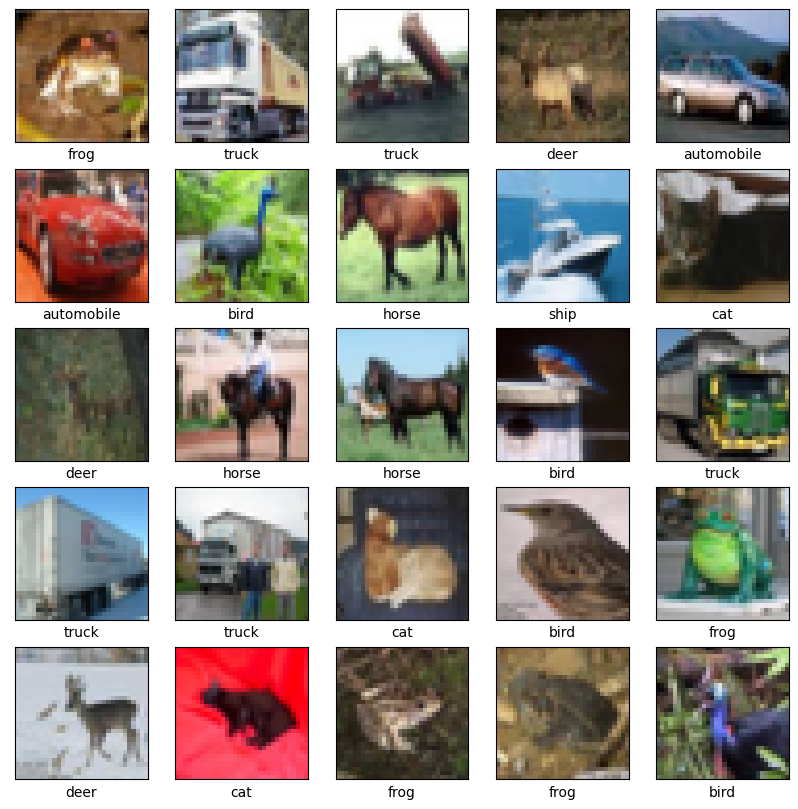

In [61]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

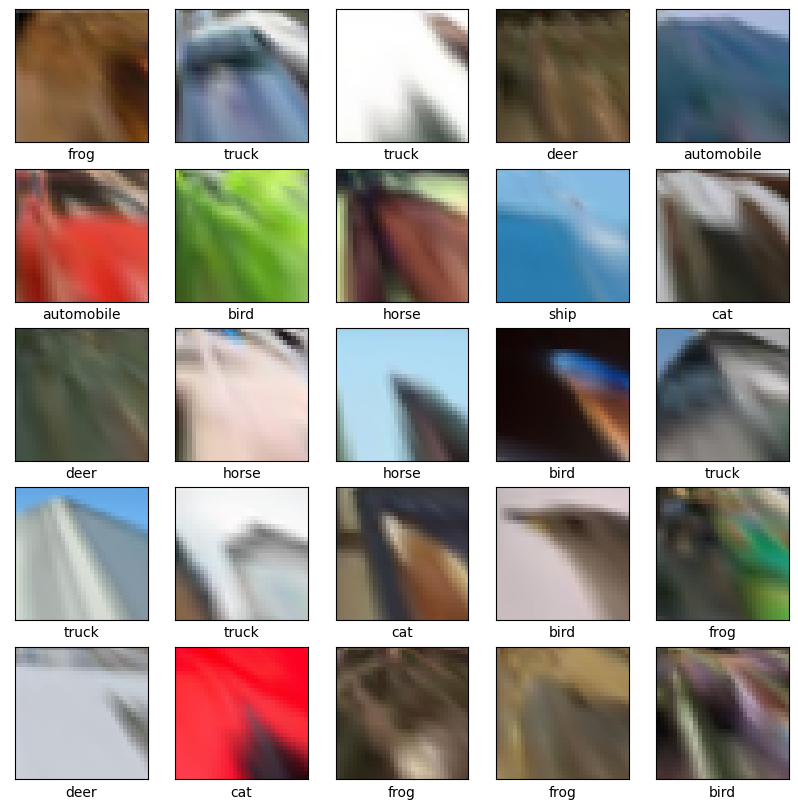

In [62]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

transforms = [
    1.0, 0.0, 0,
    0.0, 1.0, 0,
    0.01, 0.05]

#  [a0, a1, a2, b0, b1, b2, c0, c1],
#  then it maps the output point (x, y)
#  to a transformed
#  input point (x', y') = ((a0 x + a1 y + a2) / k, (b0 x + b1 y + b2) / k),
#  where k = c0 x + c1 y + 1
x_train_transformed = \
    tfa.image.transform(
        images=x_train,
        transforms=transforms,
        interpolation="bilinear",
        fill_mode="constant",
        fill_value=0)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_transformed[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [63]:
# x = np.linspace(0, 1, 4)
# y = np.linspace(0, 1, 4)
# X, Y = tf.meshgrid(x, y)
# transforms = [
#     1.0, 0.0, 0,
#     0.0, 1.0, 0,
#     0.0, 0.0]
#
# plt.figure(figsize=(5,5))
# plt.subplot(121)
# plt.imshow(X)
# plt.subplot(122)
# X_tr = \
#     tfa.image.transform(
#         images=X,
#         transforms=transforms,
#         interpolation="bilinear",
#         fill_mode="constant",
#         fill_value=-999)
# plt.imshow(X_tr)
# plt.show()
#
# plt.figure(figsize=(5,5))
# plt.subplot(121)
# plt.imshow(Y)
# plt.subplot(122)
# Y_tr = \
#     tfa.image.transform(
#         images=Y,
#         transforms=transforms,
#         interpolation="bilinear",
#         fill_mode="constant",
#         fill_value=-999)
# plt.imshow(Y_tr)
# plt.show()
#
# X_r = tf.reshape(X, shape=(-1,1))
# Y_r = tf.reshape(Y, shape=(-1,1))
# XY_r = tf.concat([X_r, Y_r], axis=1)
#
# X_tr_r = tf.reshape(X_tr, shape=(-1,1))
# Y_tr_r = tf.reshape(Y_tr, shape=(-1,1))
# XY_tr_r = tf.concat([X_tr_r, Y_tr_r], axis=1)
#
# XY_dist = XY_r - XY_tr_r
# XY_dist = tf.linalg.matmul(XY_dist, tf.transpose(XY_dist))
# XY_dist = tf.sqrt(XY_dist)
#
# plt.figure(figsize=(5,5))
# plt.imshow(XY_dist)
# plt.show()

In [64]:
input_layer = keras.Input(shape=input_shape)

x = keras.layers.Conv2D(filters=32,
                        padding="same",
                        strides=(1, 1),
                        use_bias=False,
                        kernel_size=(5, 5),
                        activation="relu",
                        kernel_regularizer=None)(input_layer)

output_layer = x

model = \
    tf.keras.Model(
        inputs=input_layer,
        outputs=output_layer)

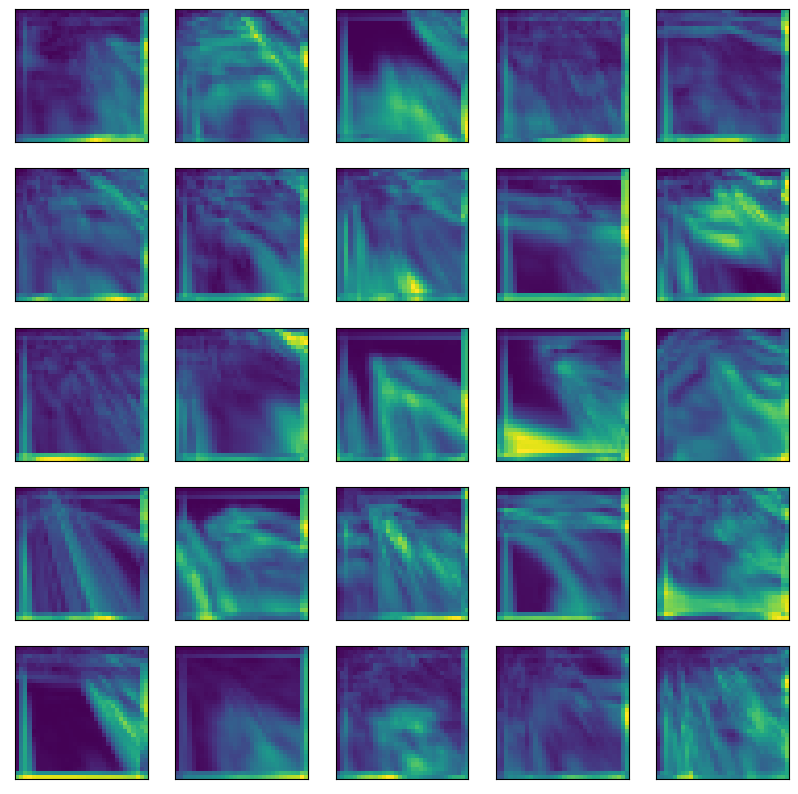

In [69]:
transforms = [
    1.0, 0.0, 0,
    0.0, 1.0, 0,
    0.01, 0.05]
# get sample, convert to features map, transform
x_train_sample = x_train[0:25,:,:,:]
x_features = model(x_train_sample-0.5, training=False)
x_features_transformed = \
    tfa.image.transform(
        images=x_features,
        transforms=transforms,
        interpolation="bilinear",
        fill_mode="constant",
        fill_value=-999)
# get sample, transform it, convert to features map
x_train_sample = x_train[0:25,:,:,:]
x_transformed = \
    tfa.image.transform(
        images=x_train_sample,
        transforms=transforms,
        interpolation="bilinear",
        fill_mode="constant",
        fill_value=-999)
x_transformed_features = model(x_transformed-0.5, training=False)

x_features_diff = tf.abs(x_transformed_features - x_features_transformed)
x_features_diff = tf.reduce_sum(x_features_diff, axis=[3])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_features_diff[i])
plt.show()